This notebook contains some tests to decide on an experimental design for the simulatability experiment.

In [1]:
import krippendorff


In [2]:
from scipy.stats import ttest_ind

In [3]:

import numpy as np 
import scipy.stats as stats 
import matplotlib.pyplot as plt


In [4]:
import pandas as pd
import numpy as np

In [5]:
import random

## Hase et al. 2020.

This is a within-subject* design with 4 phases: (1) Predictions only, (2) Pre-learn test, (3) Teaching: Predictions + Explanations, (4) Eval.

Phase 1 and 3 share a set of documents as do 2 and 4.

Result: Report **average change** in user accuracy per explanation method (phase 2 vs. 4), CI and p values of mean

Additional parameters in Hase et al.:
- Balance data "by model correctness" so random guessing can't succeed: *"we ensure that true positives, false positives,
true negatives, and false negatives are equally represented in the inputs. [...] We confirm user understanding of the data
balancing in our screening test"*
- Forced choice, to not "favor overly niche explanations" (like in Ribeiro et al.)
- Separate teach and test phases
- Pre prediction phase to obtain a baseline
- **All users see the same examples**


*: One explanation method per user, some users repeat the experiment with a new dataset!?!



### Feasability

In [6]:
columns_experiment = ["user_id", "document_id", "user_label"]


In [7]:
def guess_post(detector_label):
    return detector_label if bool(np.random.choice([0,1],p=[0.4,0.6])) else ~detector_label
def guess_pre(detector_label):
    return detector_label if bool(np.random.choice([0,1],p=[0.5,0.5])) else ~detector_label

In [8]:
def user_metrics(user_df, df_detector_output):
    df = user_df.join(df_detector_output, on="document_id")

   # display(df)
    TP = ((df["detector_label"]) & (df["user_label"])).sum()
    FP = ((~df["detector_label"]) & (df["user_label"])).sum()

    TN = ((~df["detector_label"]) & (~df["user_label"])).sum()
    FN = ((df["detector_label"]) & (~df["user_label"])).sum()

    acc = (TP+TN) / (TP+FP+TN+FN)
    # print("acc", acc)
    # print("TP", TP)
    # print("FP", FP)
    # print("TN", TN)
    # print("FN", FN)


    assert sum([TP,FP,TN,FN]) == len(df), "Check that input is bool"
    assert (acc ==(df["user_label"] == df["detector_label"]).sum() / len(df)), "Check that input is bool: acc"

    return pd.DataFrame([(TP,TN,FP,FN, acc)], columns=["TP","TN","FP","FN", "User Accuracy"])

In [9]:
def evaluate_user_study(df_detector_output, df_pre, df_eval):
    # "Reproducing" information from Table 1/2 in Hase et al.:
    user_metrics_pre = df_pre.groupby(["user_id"]).apply(lambda x : user_metrics(x,df_detector_output))

    user_metrics_eval = df_eval.groupby(["user_id"]).apply(lambda x : user_metrics(x,df_detector_output)) # TODO
    df_change = user_metrics_eval - user_metrics_pre
    df_change = df_change.rename(columns={"User Accuracy": "Change in User Accuracy"})

    user_acc_col = df_change["Change in User Accuracy"] # for convenience

    # use student t for low number of samples
    lower, upper = stats.t.interval(
    confidence=0.95, 
    df=len(user_acc_col)-1, # degrees of freedom = # samples - 1 for mean
              loc=user_acc_col.mean(), 
              scale=stats.sem(user_acc_col)
              ) 
    
    p_val = ttest_ind(user_metrics_eval["User Accuracy"],user_metrics_pre["User Accuracy"]).pvalue

#    k_alpha = krippendorff.alpha(reliability_data=df_eval.groupby(["user_id"]).apply(lambda df : df["user_label"].astype(int).to_list()).to_list())



 #   lower_b, upper_b = stats.bootstrap((user_acc_col,), np.mean, confidence_level=0.95,).confidence_interval
    
    # print results
  #  print("Mean change in acc",user_acc_col.mean())
   # print("CI for mean change: [{},{}]".format(lower,upper))

    #print("CI by bootstrap: [{},{}]".format(lower_b, upper_b))

    
    #print("p=%.10f" % p_val, "significant (< 0.05)" if p_val < 0.05 else "NOT significant (> 0.05)")
    #print("Krippendorff between users: {}".format(k_alpha))
    return p_val
    

In [10]:
def mock_user_responses(df_detector_output, documents_pre_eval, users):
    responses_pre = []
    responses_eval = []
    # Phase 1: "16 examples from the validation set with labels and model predictions but no explanations"
    # Phase 2: "Then they must predict the model output for either 16 or 32 new inputs, with the number chosen based on user time constraints."
    for user_id in users:
        responses_pre += [(user_id, document_id, guess_pre(df_detector_output.loc[document_id]["detector_label"])) for document_id in documents_pre_eval]
    # Phase 3: " Next, they return to the same learning examples, now with explanations included."
    # Phase 4: " Finally, they predict model behavior again on the same instances from the first prediction round"
    for user_id in users:
        responses_eval += [(user_id, document_id,guess_post(df_detector_output.loc[document_id]["detector_label"])) for document_id in documents_pre_eval]
    return responses_pre, responses_eval

In [11]:

def mock_detector_responses(documents_pre_eval):
    df_detector_output = pd.DataFrame([(document_id, bool(random.randint(0,1)), bool(random.randint(0,1))) for document_id in documents_pre_eval], columns=["document_id", "detector_label","gold_label"])
    df_detector_output= df_detector_output.set_index("document_id")
    return df_detector_output

In [12]:
def simulate_hase(

        n_learn = 16,
        n_eval = 16,
        n_users = 12,


):
    users = ["u_%s" % i for i in range(1,n_users+1)]
    documents_learn_1_2 = ["l_%s" % i for i in range(1,n_learn+1)]
    documents_pre_eval = ["e_%s" % i for i in range(1,n_eval+1)]

    df_detector_output = mock_detector_responses(documents_pre_eval)

    responses_pre, responses_eval = mock_user_responses(df_detector_output, documents_pre_eval, users)
    df_pre =pd.DataFrame(responses_pre, columns=columns_experiment)
    df_eval =pd.DataFrame(responses_eval, columns=columns_experiment)



   # print("Each user saw {} instances. ".format(2*n_learn + 2*n_eval) )
   # print("Used {} unique documents. A set of {} in phase 1 and 3; and a set of {} in phase 2 and 4.".format(n_learn + n_eval,n_learn, n_eval))

#    print("Results based on {} unique eval documents.".format(n_eval))

#    print("Results based on {} datapoints.".format(len(responses_eval)))
    p_value = evaluate_user_study(df_detector_output, df_pre, df_eval)
    return p_value

In [13]:
simulate_hase()

0.03247614392025586

In [14]:
p_values = []
n_users_ = list(range(2,50))
for n_users in n_users_:
    p_values.append(simulate_hase(
        n_learn = 16,
        n_eval = 16,
        n_users = n_users,
        ))
    

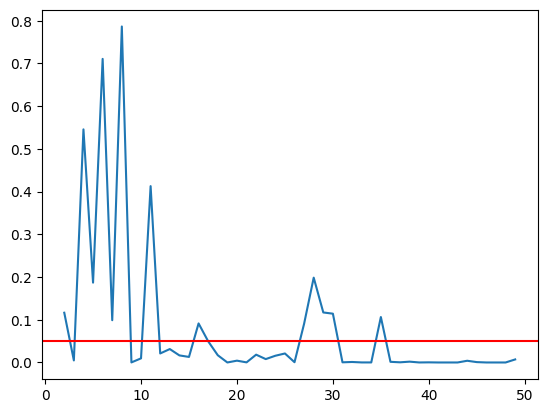

In [15]:
plt.plot(n_users_, p_values)
plt.axhline(y=0.05, color="red")